In [1]:
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_auc_score, auc, matthews_corrcoef, precision_score, recall_score
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import seaborn as sns
from matplotlib_venn import venn3
import joblib
from collections import Counter

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs


# HPC Results

In [19]:
mrDF = pd.read_excel(r'..\processed_datasets\updated_HPC_results.xlsx')
mrDF['Algorithms'] = mrDF['Algorithms'].str.replace('Balanced Random Forest','Balanced\nRandom\nForest')
mrDF['Algorithms'] = mrDF['Algorithms'].str.replace('D-MPNN with Focal_loss','D-MPNN\nwith\nFocal loss')

mrDF.Algorithms.unique()

array(['D-MPNN', 'D-MPNN\nwith\nFocal loss', 'Balanced\nRandom\nForest',
       'Random Forest on Morgan Fingerprint (max_depth=16, min_samples_leaf=12)',
       'non-Tuned MolFormer', 'HiMol (40 epochs)', 'HiMol', 'MolFormer_',
       'Random Forest on 200 RDKIT Descriptors',
       'ChemProp without RDKIT Descriptors', 'Random Forest',
       'DMPNN without molecular-level features', 'MolFormer',
       'MolFormer Random', 'MolFormer_single', 'Random Forest nonTuned'],
      dtype=object)

<Axes: xlabel='Algorithms', ylabel='AUPRC score'>

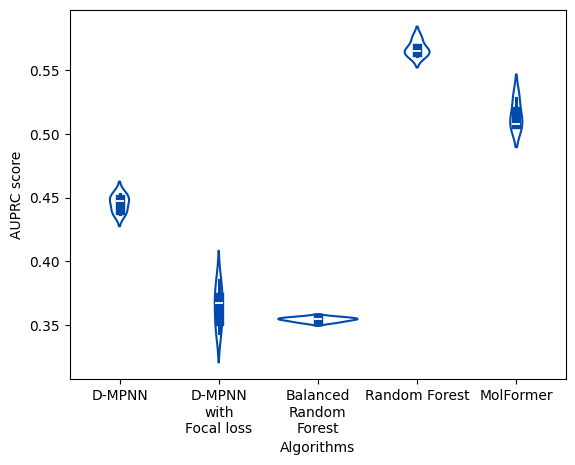

In [20]:
excl = ['D-MPNN', 'D-MPNN\nwith\nFocal loss',
        'Random Forest', 'Balanced\nRandom\nForest', 'MolFormer']
sns.violinplot(x=mrDF[mrDF.Algorithms.isin(excl)]['Algorithms'], 
               y=mrDF[mrDF.Algorithms.isin(excl)]["AUPRC score"], 
               color='#004aad', fill=False)

<Axes: xlabel='Algorithms', ylabel='MCC @0.5'>

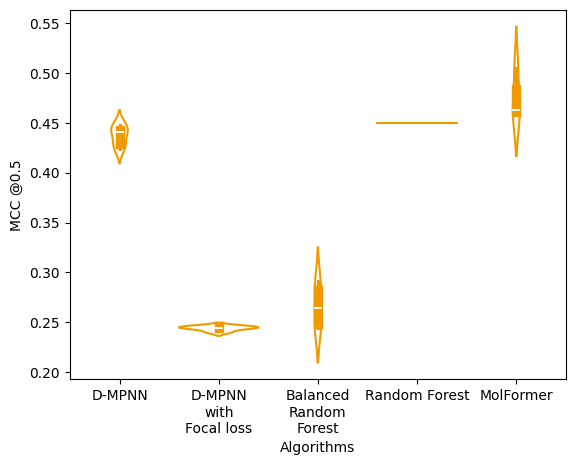

In [ ]:
sns.violinplot(x=mrDF[mrDF.Algorithms.isin(excl)]['Algorithms'], 
               y=mrDF[mrDF.Algorithms.isin(excl)]["MCC @0.5"], 
               color='#ee9a00', fill=False)
plt.savefig('filename.png', dpi=300)

# Prediction Scores

In [119]:
from scripts.predict_utils import _get_model_prediction
from deepchem.feat import DMPNNFeaturizer, CircularFingerprint
from deepchem.data import NumpyDataset
from deepchem.models.torch_models import DMPNNModel

In [234]:
stackingDF = df[['Compound ID','Smiles', 'cluster_id', 'final_activity_label']].copy()
stackingDF.tail(2)

,Compound ID,Smiles,cluster_id,final_activity_label
41162,EVANS BLUE,Cc1cc(-c2ccc(N=Nc3ccc4c(S(=O)(=O)[O-])cc(S(=O)...,-1,0
41163,PROTOPORPHYRIN IX,C=Cc1c(C)c2cc3[nH]c(cc4nc(cc5[nH]c(cc1n2)c(C)c...,3,0


## RF morgan prediction

In [214]:
fp_featurizer = CircularFingerprint(radius=3, size=2048, chiral=True)
mols = [Chem.MolFromSmiles(smiles) for smiles in stackingDF["Smiles"]]
features = fp_featurizer.featurize(mols)

fp_dataset = NumpyDataset(
    X=features, y=stackingDF["final_activity_label"], 
    ids=stackingDF["Smiles"]
)

[18:54:30] Unusual charge on atom 0 number of radical electrons set to zero


In [215]:
rfc = joblib.load(r'model_garden\tuned_rfc_morgan_seed3.joblib')
vanilla_rfc_morgan_pred = [x[1] for x in rfc.predict_proba(fp_dataset.X)]

## ChemProp Prediction

In [131]:
mpnn_featurizer = DMPNNFeaturizer(features_generators=['rdkit_desc_normalized']) # with molecular-level features

mols = [Chem.MolFromSmiles(smiles) for smiles in stackingDF["Smiles"]]
features = mpnn_featurizer.featurize(mols)

test_dataset = NumpyDataset(
    X=features, y=stackingDF["final_activity_label"], 
    ids=stackingDF["Smiles"]
)

model_ensembles = []
for i in range(26):
    model_filename = f'model_garden\__chemprop_a50y0_s1_{i}'
    model = DMPNNModel(model_dir = model_filename, 
                       n_classes=2, 
                       mode='classification', 
                       batch_size = 32, 
                        ffn_hidden = 1600,
                        # enc_dropout_p=0.1, 
                        ffn_dropout_p = 0.3, 
                        depth = 6,
                        enc_activation = 'gelu',
                        ffn_activation = 'gelu',
                        bias = True,
                        aggregation = "sum",
                       global_features_size=200)
    model.restore()
    model_ensembles.append(model)

cp_pred, cp_uncertainty = _get_model_prediction(model_ensembles, test_dataset, agg_fn='median')
cp_precision, cp_recall, cp_thresholds = precision_recall_curve(test_dataset.y, cp_pred)

[06:05:02] Unusual charge on atom 0 number of radical electrons set to zero
[06:17:25] Unusual charge on atom 0 number of radical electrons set to zero


## Molformer

In [128]:
mf_ens_output = pd.read_csv(r'processed_datasets\v7_ensembleMF_s1_output.csv')
mf_ens_output = mf_ens_output.rename(columns={'prediction':'tuned_MF_ens_pred', 'uncertainty':'tuned_MF_ens_uncertainty'})
mf_ens_output.tail(2)

,Smiles,cluster_id,tuned_MF_ens_pred,tuned_MF_ens_uncertainty
41162,Cc1cc(-c2ccc(N=Nc3ccc4c(S(=O)(=O)[O-])cc(S(=O)...,-1,0.421019,0.084818
41163,C=Cc1c(C)c2cc3[nH]c(cc4nc(cc5[nH]c(cc1n2)c(C)c...,3,0.078812,0.103564


## Combine

In [216]:
stackingDF['tuned_rfc_morgan_pred'] = vanilla_rfc_morgan_pred
# stackingDF['vanilla_rfc_molfeat_pred'] = vanilla_rfc_molfeat_pred
# stackingDF['cp_pred'] = cp_pred
# stackingDF['cp_uncertainty'] = cp_uncertainty
# stackingDF = stackingDF.merge(mf_ens_output, on=['Smiles','cluster_id'])
stackingDF.to_csv(r'processed_datasets\v7_predictions_for_stacking_v2.csv', index=False)


In [ ]:
testDF = df[['Smiles', 'adjusted_value_uM', 'Compound ID']].merge(stackingDF, on='Smiles')
testDF.to_csv(r'processed_datasets\top_algo_holdout_set_output_v7_tuned.csv', index=False)

# Tuned Threshold Classifier

In [201]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [197]:
stackingDF = pd.read_csv(r'processed_datasets\v7_predictions_for_stacking.csv')
train_df = stackingDF[stackingDF.cluster_id!=-1]
col = 'vanilla_rfc_morgan_pred'

nSplit = 5
cv = StratifiedKFold(n_splits=nSplit, shuffle=True)
rfc_morgan_score_cv = cv.split(train_df['vanilla_rfc_morgan_pred'], train_df['final_activity_label'])
rfc_morgan_score_cv

<generator object _BaseKFold.split at 0x00000173803FE660>

In [202]:
fp_featurizer = CircularFingerprint(radius=3, size=2048, chiral=True)
mols = [Chem.MolFromSmiles(smiles) for smiles in train_df["Smiles"]]
features = fp_featurizer.featurize(mols)

fp_dataset = NumpyDataset(
    X=features, y=train_df["final_activity_label"], 
    ids=train_df["Smiles"]
)

[16:37:39] Unusual charge on atom 0 number of radical electrons set to zero


In [206]:
threshold_choices = [0.1*x for x in range(1,8)]
mcc_at_thresh = np.zeros((len(threshold_choices), nSplit))

for cv_id, (cv_train_idx, cv_test_idx) in enumerate(rfc_morgan_score_cv):
    for tidx, threshold in enumerate(threshold_choices):
        rfc = RandomForestClassifier(n_estimators=200, random_state=3, 
                                     criterion='entropy', class_weight='balanced', min_samples_leaf=4, max_depth=256)
        rfc.fit(fp_dataset.select(cv_train_idx).X, fp_dataset.select(cv_train_idx).y)
        pred = [x[1] for x in rfc.predict_proba(fp_dataset.select(cv_test_idx).X)]
        mcc_at_thresh[tidx][cv_id] = matthews_corrcoef(fp_dataset.select(cv_test_idx).y, 
                                                     [x>threshold for x in pred])

In [207]:
avg_mcc_at_thresh = np.mean(mcc_at_thresh, axis=1)
best_threshold_idx = np.argmax(avg_mcc_at_thresh)
threshold_choices[best_threshold_idx]

0.6000000000000001

# Analysis v2

In [2]:
testDF = pd.read_csv(r'processed_datasets\top_algo_holdout_set_output_v7_tuned.csv')
testDF.columns

Index(['Smiles', 'adjusted_value_uM', 'Compound ID', 'cluster_id',
       'final_activity_label', 'rfc_morgan_pred', 'cp_pred', 'cp_uncertainty',
       'tuned_MF_ens_pred', 'tuned_MF_ens_uncertainty',
       'tuned_rfc_morgan_pred'],
      dtype='object')

In [4]:
testDF['MolFormer_n_ChemProp_prediction'] = [np.min([x,y]) for x,y in zip(testDF['cp_pred'], testDF['tuned_MF_ens_pred'])]
testDF['MolFormer_OR_ChemProp_prediction'] = [np.max([x,y]) for x,y in zip(testDF['cp_pred'], testDF['tuned_MF_ens_pred'])]
# testDF['is_MolFormer_n_ChemProp_prediction'] = [x>0.4 and y>0.5 for x,y in zip(testDF['cp_pred'], testDF['tuned_MF_ens_pred'])]
testDF['RFC_morgan_n_ChemProp_prediction'] = [np.min([x,y]) for x,y in zip(testDF['cp_pred'], testDF['tuned_rfc_morgan_pred'])]
testDF['RFC_morgan_OR_ChemProp_prediction'] = [np.max([x,y]) for x,y in zip(testDF['cp_pred'], testDF['tuned_rfc_morgan_pred'])]
testDF['MolFormer_n_RFC_morgan_prediction'] = [np.min([x,y]) for x,y in zip(testDF['tuned_MF_ens_pred'], testDF['tuned_rfc_morgan_pred'])]
testDF['MolFormer_OR_RFC_morgan_prediction'] = [np.max([x,y]) for x,y in zip(testDF['tuned_MF_ens_pred'], testDF['tuned_rfc_morgan_pred'])]
# testDF['RFC_molfeat_n_ChemProp_prediction'] = [np.min([x,y]) for x,y in zip(testDF['cp_pred'], testDF['vanilla_rfc_molfeat_pred'])]
# testDF['RFC_molfeat_OR_ChemProp_prediction'] = [np.max([x,y]) for x,y in zip(testDF['cp_pred'], testDF['vanilla_rfc_molfeat_pred'])]
# testDF['MolFormer_n_RFC_molfeat_prediction'] = [np.min([x,y]) for x,y in zip(testDF['tuned_MF_ens_pred'], testDF['vanilla_rfc_molfeat_pred'])]
# testDF['MolFormer_OR_RFC_molfeat_prediction'] = [np.max([x,y]) for x,y in zip(testDF['tuned_MF_ens_pred'], testDF['vanilla_rfc_molfeat_pred'])]
testDF['all_prediction'] = [np.min([x,y,z]) for x,y,z in zip(testDF['tuned_MF_ens_pred'], testDF['tuned_rfc_morgan_pred'],testDF['cp_pred'])]
testDF['any_prediction'] = [np.max([x,y,z]) for x,y,z in zip(testDF['tuned_MF_ens_pred'], testDF['tuned_rfc_morgan_pred'],testDF['cp_pred'])]
testDF.head(2)

,Smiles,adjusted_value_uM,Compound ID,cluster_id,final_activity_label,rfc_morgan_pred,cp_pred,cp_uncertainty,tuned_MF_ens_pred,tuned_MF_ens_uncertainty,tuned_rfc_morgan_pred,MolFormer_n_ChemProp_prediction,MolFormer_OR_ChemProp_prediction,RFC_morgan_n_ChemProp_prediction,RFC_morgan_OR_ChemProp_prediction,MolFormer_n_RFC_morgan_prediction,MolFormer_OR_RFC_morgan_prediction,all_prediction,any_prediction
0,CCOC1=C(C)C(=O)c2ccn3c(C)ncc3c2C1=O,7.399460,CHEMBL447648,-1,1,0.012000,0.000523,0.008489,0.096068,0.047358,0.114098,0.000523,0.096068,0.000523,0.114098,0.096068,0.114098,0.000523,0.114098
1,CCO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(Sc...,0.365123,CHEMBL501122,-1,1,0.562567,0.894765,0.101058,0.906806,0.097809,0.654945,0.894765,0.906806,0.654945,0.894765,0.654945,0.906806,0.654945,0.906806


In [5]:
mcc50s, precs, recs, auprcs, collist, roc_aucs = [], [], [], [], [], []
for col in [x for x in testDF.columns if '_pred' in x]:
    p_precision, p_recall, thresholds = precision_recall_curve(testDF['final_activity_label'], testDF[col])
    collist.append(col)
    mcc50s.append(matthews_corrcoef(testDF['final_activity_label'], testDF[col]>0.5))
    precs.append(precision_score(testDF['final_activity_label'], testDF[col]>0.5))
    recs.append(recall_score(testDF['final_activity_label'], testDF[col]>0.5))
    auprcs.append(auc(p_recall, p_precision))
    roc_aucs.append(roc_auc_score(testDF['final_activity_label'], testDF[col]))
    # print(col)
    # print('\tMCC @0.5: ', matthews_corrcoef(holdset['final_activity_label'], holdset[col]>0.5))
    # print('\tprecision: ', precision_score(holdset['final_activity_label'], holdset[col]>0.5))
    # print('\trecall: ', recall_score(holdset['final_activity_label'], holdset[col]>0.5))
    # print('\tAUPRC: ', auc(p_recall, p_precision))
res_summary2 = pd.DataFrame({
                        'algo':collist,
                        'MCC @0.5':mcc50s,
                        'precision':precs,
                        'recall':recs,
                        'PR-AUC':auprcs,
                        'ROC-AUC':roc_aucs
                    })
res_summary2.sort_values('PR-AUC', ascending=False)

,algo,MCC @0.5,precision,recall,PR-AUC,ROC-AUC
8,MolFormer_n_RFC_morgan_prediction,0.492961,1.000000,0.244898,0.630464,0.978576
10,all_prediction,0.426783,1.000000,0.183673,0.597125,0.974118
9,MolFormer_OR_RFC_morgan_prediction,0.555670,0.590909,0.530612,0.589823,0.979215
0,rfc_morgan_pred,0.449916,1.000000,0.204082,0.574548,0.951351
4,MolFormer_n_ChemProp_prediction,0.514186,0.933333,0.285714,0.564802,0.973874
11,any_prediction,0.488074,0.442623,0.551020,0.549801,0.977634
5,MolFormer_OR_ChemProp_prediction,0.477747,0.440678,0.530612,0.546609,0.984438
6,RFC_morgan_n_ChemProp_prediction,0.473265,0.923077,0.244898,0.537786,0.950565
2,tuned_MF_ens_pred,0.505441,0.578947,0.448980,0.528117,0.975153
3,tuned_rfc_morgan_pred,0.536313,0.888889,0.326531,0.526027,0.963151


In [276]:
MCC_sorted_summary = res_summary2[~res_summary2.algo.str.contains('molfeat')].sort_values('MCC @0.5', ascending=False)
MCC_sorted_summary.to_csv(r'Results\MCC_sorted_summary.csv', index=False)
MCC_sorted_summary

,algo,MCC @0.5,precision,recall,PR-AUC,ROC-AUC
10,MolFormer_OR_RFC_morgan_prediction,0.555670,0.590909,0.530612,0.589823,0.979215
4,tuned_rfc_morgan_pred,0.536313,0.888889,0.326531,0.526027,0.963151
5,MolFormer_n_ChemProp_prediction,0.514186,0.933333,0.285714,0.564802,0.973876
3,tuned_MF_ens_pred,0.505441,0.578947,0.448980,0.528117,0.975153
9,MolFormer_n_RFC_morgan_prediction,0.492961,1.000000,0.244898,0.630464,0.978576
16,any_prediction,0.488074,0.442623,0.551020,0.549801,0.977634
8,RFC_morgan_OR_ChemProp_prediction,0.486063,0.536585,0.448980,0.475113,0.960709
6,MolFormer_OR_ChemProp_prediction,0.477747,0.440678,0.530612,0.546609,0.984438
7,RFC_morgan_n_ChemProp_prediction,0.473265,0.923077,0.244898,0.537786,0.950567
0,vanilla_rfc_morgan_pred,0.449916,1.000000,0.204082,0.574548,0.951351


In [322]:
testDF.columns

Index(['Smiles', 'adjusted_value_uM', 'Compound ID', 'cluster_id',
       'final_activity_label', 'vanilla_rfc_morgan_pred',
       'vanilla_rfc_molfeat_pred', 'cp_pred', 'cp_uncertainty',
       'tuned_MF_ens_pred', 'tuned_MF_ens_uncertainty',
       'tuned_rfc_morgan_pred', 'MolFormer_n_ChemProp_prediction',
       'MolFormer_OR_ChemProp_prediction', 'RFC_morgan_n_ChemProp_prediction',
       'RFC_morgan_OR_ChemProp_prediction',
       'MolFormer_n_RFC_morgan_prediction',
       'MolFormer_OR_RFC_morgan_prediction',
       'RFC_molfeat_n_ChemProp_prediction',
       'RFC_molfeat_OR_ChemProp_prediction',
       'MolFormer_n_RFC_molfeat_prediction',
       'MolFormer_OR_RFC_molfeat_prediction', 'all_prediction',
       'any_prediction'],
      dtype='object')

In [ ]:
mcc50s, precs, recs, auprcs, collist, roc_aucs = [], [], [], [], [], []
lowSimTestDF = testDF[testDF.]
for col in [x for x in testDF.columns if '_pred' in x]:
    p_precision, p_recall, thresholds = precision_recall_curve(testDF['final_activity_label'], testDF[col])
    collist.append(col)
    mcc50s.append(matthews_corrcoef(testDF['final_activity_label'], testDF[col]>0.5))
    precs.append(precision_score(testDF['final_activity_label'], testDF[col]>0.5))
    recs.append(recall_score(testDF['final_activity_label'], testDF[col]>0.5))
    auprcs.append(auc(p_recall, p_precision))
    roc_aucs.append(roc_auc_score(testDF['final_activity_label'], testDF[col]))
    # print(col)
    # print('\tMCC @0.5: ', matthews_corrcoef(holdset['final_activity_label'], holdset[col]>0.5))
    # print('\tprecision: ', precision_score(holdset['final_activity_label'], holdset[col]>0.5))
    # print('\trecall: ', recall_score(holdset['final_activity_label'], holdset[col]>0.5))
    # print('\tAUPRC: ', auc(p_recall, p_precision))
res_summary2 = pd.DataFrame({
                        'algo':collist,
                        'MCC @0.5':mcc50s,
                        'precision':precs,
                        'recall':recs,
                        'PR-AUC':auprcs,
                        'ROC-AUC':roc_aucs
                    })
res_summary2.sort_values('PR-AUC', ascending=False)

## PR-AUC

Text(0.5, 0, 'Recall')

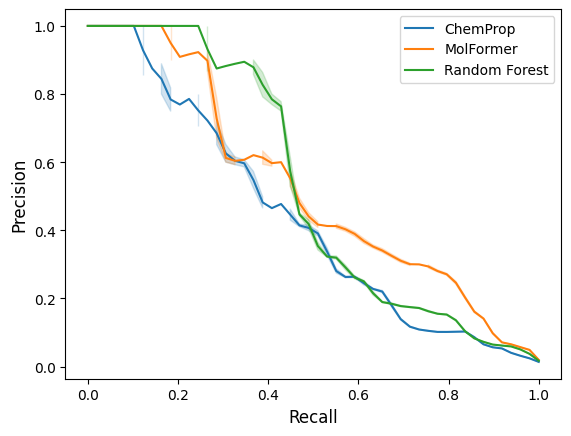

In [249]:
test_resultDF = pd.DataFrame()
col_preds = ['cp_pred', 'tuned_MF_ens_pred', 'tuned_rfc_morgan_pred']
algonames = ['ChemProp', 'MolFormer', 'Random Forest', 'Molformer & ChemProp', 'Molformer & Random Forest', 'ChemProp & Random Forest']

for i, col in enumerate(col_preds):
    p_precision, p_recall, thresholds = precision_recall_curve(testDF['final_activity_label'], testDF[col])
    tmp = pd.DataFrame({'algorithm':algonames[i], 'precision':p_precision, 'recall':p_recall})
    test_resultDF = pd.concat([test_resultDF, tmp])

ax = sns.lineplot(test_resultDF, x ='recall', y='precision', hue='algorithm')
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel('Precision', fontsize='large')
ax.set_xlabel('Recall', fontsize='large')

Text(0.5, 0, 'Recall')

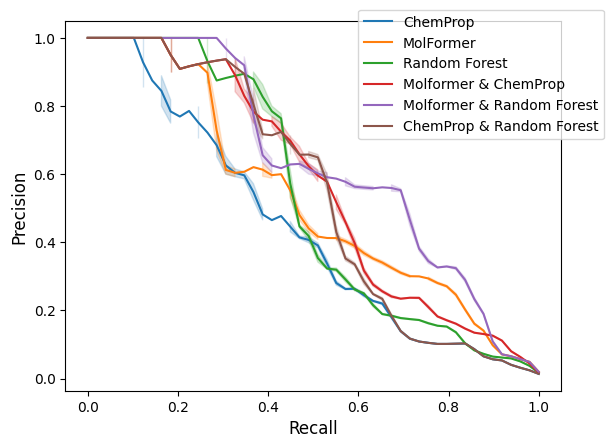

In [250]:
test_resultDF = pd.DataFrame()
col_preds = ['cp_pred', 'tuned_MF_ens_pred', 'tuned_rfc_morgan_pred', 'MolFormer_n_ChemProp_prediction', 'MolFormer_n_RFC_morgan_prediction', 'RFC_morgan_n_ChemProp_prediction']
algonames = ['ChemProp', 'MolFormer', 'Random Forest', 'Molformer & ChemProp', 'Molformer & Random Forest', 'ChemProp & Random Forest']

for i, col in enumerate(col_preds):
    p_precision, p_recall, thresholds = precision_recall_curve(testDF['final_activity_label'], testDF[col])
    tmp = pd.DataFrame({'algorithm':algonames[i], 'precision':p_precision, 'recall':p_recall})
    test_resultDF = pd.concat([test_resultDF, tmp])

ax = sns.lineplot(test_resultDF, x ='recall', y='precision', hue='algorithm')
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_ylabel('Precision', fontsize='large')
ax.set_xlabel('Recall', fontsize='large')

## Venn Diagram

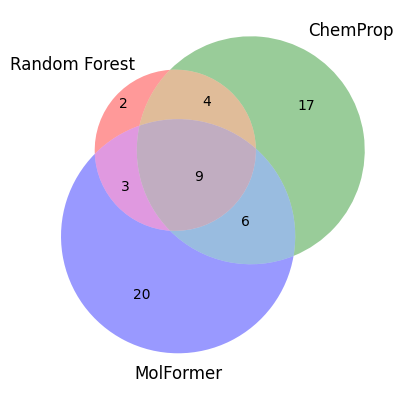

In [239]:
rfc = testDF[testDF.tuned_rfc_morgan_pred>0.5][['Compound ID', 'Smiles', 'tuned_rfc_morgan_pred', 'final_activity_label']]
set1 = set(rfc['Smiles'].values)
chemprop = testDF[testDF.cp_pred>0.5][['Compound ID', 'Smiles', 'cp_pred', 'final_activity_label']]
set2 = set(chemprop['Smiles'].values)
mformer = testDF[testDF.tuned_MF_ens_pred>0.5][['Compound ID', 'Smiles', 'tuned_MF_ens_pred', 'final_activity_label']]
set3 = set(mformer['Smiles'].values)

vax = venn3([set1, set2, set3], ('Random Forest', 'ChemProp', 'MolFormer'))

plt.show()

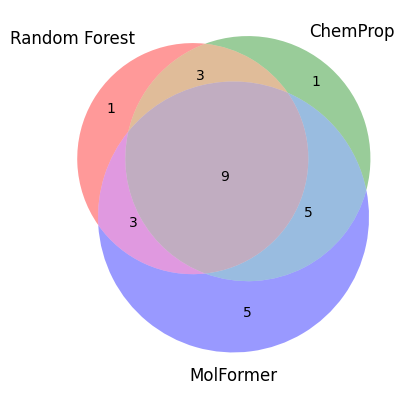

In [240]:
set1 = set(rfc[rfc['final_activity_label']==1]['Smiles'].values)
set2 = set(chemprop[chemprop['final_activity_label']==1]['Smiles'].values)
set3 = set(mformer[mformer['final_activity_label']==1]['Smiles'].values)

venn3([set1, set2, set3], ('Random Forest', 'ChemProp', 'MolFormer'))

plt.show()

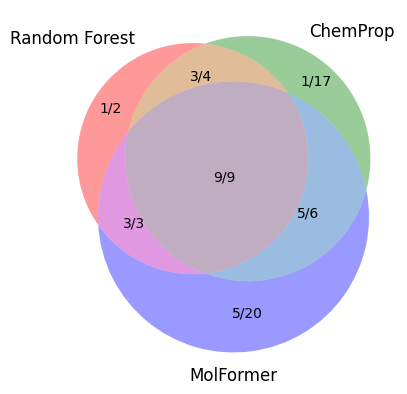

In [241]:
vax = venn3([set1, set2, set3], ('Random Forest', 'ChemProp', 'MolFormer'))

vax.get_label_by_id('100').set_text('1/2')
vax.get_label_by_id('010').set_text('1/17')
vax.get_label_by_id('001').set_text('5/20')
vax.get_label_by_id('110').set_text('3/4')
vax.get_label_by_id('011').set_text('5/6')
vax.get_label_by_id('101').set_text('3/3')
vax.get_label_by_id('111').set_text('9/9')

plt.show()

## Structural Novelty Analysis

In [ ]:
df = pd.read_csv(r'processed_datasets\10uM_FP_clustered__resistant_pneumococcus_augmented_dataset_v7.csv')
train_idx = df[df.cluster_id!=-1].index.values 
test_idx = df[df.cluster_id==-1].index.values
active_test_idx = df[(df.cluster_id==-1) & (df.final_activity_label==1)].index.values
active_train_idx = df[(df.cluster_id!=-1) & (df.final_activity_label==1)].index.values
inactive_train_idx = df[(df.cluster_id!=-1) & (df.final_activity_label==0)].index.values

In [265]:
active_test_df = testDF[(testDF.final_activity_label==1)].reset_index(drop=True).reset_index()
active_test_df.head(2)

,index,Smiles,adjusted_value_uM,Compound ID,cluster_id,final_activity_label,vanilla_rfc_morgan_pred,vanilla_rfc_molfeat_pred,cp_pred,cp_uncertainty,tuned_MF_ens_pred,tuned_MF_ens_uncertainty,tuned_rfc_morgan_pred
0,0,CCOC1=C(C)C(=O)c2ccn3c(C)ncc3c2C1=O,7.399460,CHEMBL447648,-1,1,0.012000,0.02,0.000523,0.008489,0.096068,0.047358,0.114098
1,1,CCO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(Sc...,0.365123,CHEMBL501122,-1,1,0.562567,0.85,0.894765,0.101058,0.906806,0.097809,0.654945


In [256]:
active_maxSim = joblib.load(r'processed_datasets\train_active_maxSim_tanimoto_sim_matrix.joblib')
inactive_maxSim = joblib.load(r'processed_datasets\train_inactive_maxSim_tanimoto_sim_matrix.joblib')
active_maxSim.shape

(49, 1849)

In [257]:
active_maxSim_idx = np.argmax(active_maxSim, axis=1)
inactive_maxSim_idx = np.argmax(inactive_maxSim, axis=1)
active_maxSim_idx[:2]

array([1376, 1361], dtype=int64)

In [267]:
active_test_df['train_active_maxSim_idx'] = active_maxSim_idx
active_test_df['train_active_maxSim_value'] = [m[n] for m,n in zip(active_maxSim, active_maxSim_idx)]
active_test_df['train_inactive_maxSim_idx'] = inactive_maxSim_idx
active_test_df['train_inactive_maxSim_value'] = [m[n] for m,n in zip(inactive_maxSim, inactive_maxSim_idx)]
active_test_df['train_maxSim_is_active'] = active_test_df['train_active_maxSim_value'] > active_test_df['train_inactive_maxSim_value']
# pd.DataFrame([(i, x) for i,x in enumerate(molecule_maxSim_idx)], columns=['index', 'train_maxSim_idx'])

tuned_rfc_morgan_pred % most similar is active 0.875
tuned_MF_ens_pred % most similar is active 0.7727272727272727
cp_pred % most similar is active 0.8888888888888888


<Axes: xlabel='algorithm', ylabel='Max Tanimoto Similarity in Train Set'>

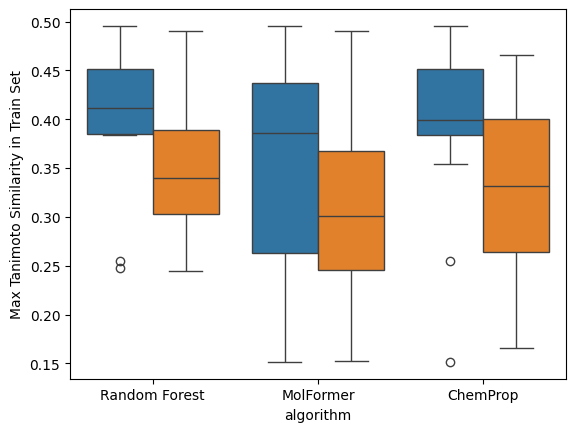

In [268]:
forBP = pd.DataFrame()
potency = pd.DataFrame()
algonames = ['Random Forest', 'MolFormer', 'ChemProp']
for i, col in enumerate(['tuned_rfc_morgan_pred', 'tuned_MF_ens_pred', 'cp_pred']):
    print(f'{col} % most similar is active', active_test_df[active_test_df[col]>0.5]['train_maxSim_is_active'].mean())
    for typse in ['_active', '_inactive']:
        tmp = active_test_df[active_test_df[col]>0.5][[x for x in active_test_df.columns if 'value' in x and typse in x]]
        tmp.columns = ['Max Tanimoto Similarity in Train Set']
        tmp['algorithm'] = algonames[i]
        tmp['type'] = typse
        forBP = pd.concat([forBP, tmp])
        
    tmp2 = active_test_df[active_test_df[col]>0.5][['adjusted_value_uM']]
    tmp2.columns = ['MIC (uM)']
    tmp2['algorithm'] = algonames[i]
    potency = pd.concat([potency, tmp2])

    # print(col)
    
    # ax = sns.boxplot()
    # print(f'{col} median active similarity', active_test_df[active_test_df[col]>0.5]['train_active_maxSim_value'].median())
    # iqr = active_test_df[active_test_df[col]>0.5]['train_active_maxSim_value'].quantile(0.75) - active_test_df[active_test_df[col]>0.5]['train_active_maxSim_value'].quantile(0.25)
    # print(f'{col} IQR active similarity', iqr)
    # print(f'{col} mean active similarity', active_test_df[active_test_df[col]>0.5]['train_active_maxSim_value'].mean())
    # print(f'{col} std active similarity', active_test_df[active_test_df[col]>0.5]['train_active_maxSim_value'].std())

    # print(f'{col} median INactive similarity', active_test_df[active_test_df[col]>0.5]['train_inactive_maxSim_value'].median())
    # iqr = active_test_df[active_test_df[col]>0.5]['train_inactive_maxSim_value'].quantile(0.75) - active_test_df[active_test_df[col]>0.5]['train_inactive_maxSim_value'].quantile(0.25)
    # print(f'{col} IQR INactive similarity', iqr)
    # print(f'{col} mean INactive similarity', active_test_df[active_test_df[col]>0.5]['train_inactive_maxSim_value'].mean())
    # print(f'{col} std INactive similarity', active_test_df[active_test_df[col]>0.5]['train_inactive_maxSim_value'].std())
    # print('#####')
sns.boxplot(forBP, x='algorithm', y='Max Tanimoto Similarity in Train Set', hue='type')

Text(0.5, 0, 'Algorithms')

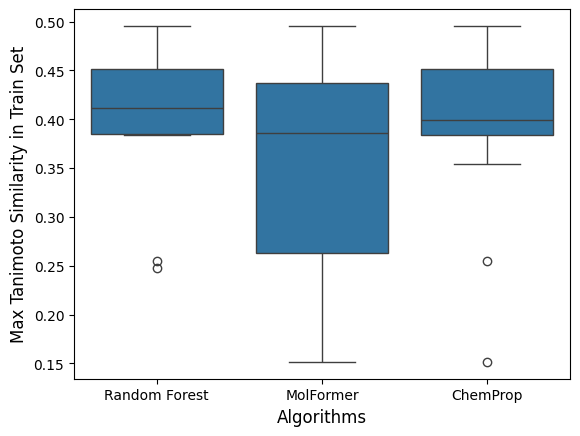

In [269]:
ax = sns.boxplot(forBP[forBP.type=='_active'], x='algorithm', y='Max Tanimoto Similarity in Train Set', hue='type')
ax.set_ylabel('Max Tanimoto Similarity in Train Set', fontsize='large')
ax.set_xlabel('Algorithms', fontsize='large')

<Axes: xlabel='algorithm', ylabel='MIC (uM)'>

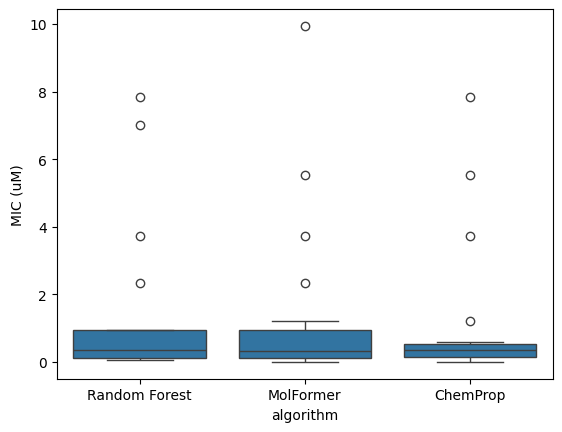

In [270]:
sns.boxplot(potency, x='algorithm', y='MIC (uM)')

### Top 5 each algo

In [277]:
active_test_df.columns

Index(['index', 'Smiles', 'adjusted_value_uM', 'Compound ID', 'cluster_id',
       'final_activity_label', 'vanilla_rfc_morgan_pred',
       'vanilla_rfc_molfeat_pred', 'cp_pred', 'cp_uncertainty',
       'tuned_MF_ens_pred', 'tuned_MF_ens_uncertainty',
       'tuned_rfc_morgan_pred', 'train_active_maxSim_idx',
       'train_active_maxSim_value', 'train_inactive_maxSim_idx',
       'train_inactive_maxSim_value', 'train_maxSim_is_active'],
      dtype='object')

In [313]:
top5_each_algo = pd.DataFrame()
algonames = ['Random Forest', 'MolFormer', 'ChemProp']

for i, col in enumerate(['tuned_rfc_morgan_pred', 'tuned_MF_ens_pred', 'cp_pred']):
    tmp = active_test_df[active_test_df[col]>0.5].sort_values('train_active_maxSim_value').iloc[:5]
    tmp['rank'] = tmp['train_active_maxSim_value'].rank(method='first')
    tmp['algo'] = algonames[i]
    top5_each_algo = pd.concat([top5_each_algo, tmp])

top5_each_algo = top5_each_algo[['Smiles', 'adjusted_value_uM', 'Compound ID', 'train_active_maxSim_idx', 'train_active_maxSim_value','algo']]
top5_each_algo[top5_each_algo.Smiles.duplicated()]

,Smiles,adjusted_value_uM,Compound ID,train_active_maxSim_idx,train_active_maxSim_value,algo
9,CCN(CC)CCS(=O)(=O)[C@@H]1CCN2C(=O)c3coc(n3)CC(...,0.583737,CHEMBL3137691,1482,0.151420,ChemProp
30,C[C@@H](O)[C@H]1C(=O)N2C(C(=O)O)=C(S[C@H]3CC[S...,0.357695,CHEMBL1908305,600,0.255102,ChemProp
38,CC(C(O)=C1C(=O)N(c2ccc(Cl)cc2)N(c2ccc(Cl)cc2)C...,0.397306,CHEMBL217320,254,0.383562,ChemProp


In [314]:
compoundDB = df.reset_index()[['index','Smiles', 'Compound ID', 'adjusted_value_uM']].rename(columns={'Smiles':'Most_Similar_SMILES', 
                                                                                 'Compound ID':'Most_Similar_Compound_ID',
                                                                                 'index':'train_active_maxSim_idx',
                                                                                 'adjusted_value_uM':'train_adjusted_value_uM'})
top5_each_algo = top5_each_algo.merge(compoundDB, on='train_active_maxSim_idx').rename(columns={'Compound ID':'CID'})
top5_each_algo.to_csv(r'Results\train_test_pred_active_comparison.csv', index=False)

In [285]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor

from PIL import Image
from io import BytesIO
def show_mol(d2d,mol,legend='',highlightAtoms=[]):
    d2d.DrawMolecule(mol,legend=legend, highlightAtoms=highlightAtoms)
    d2d.FinishDrawing()
    bio = BytesIO(d2d.GetDrawingText())
    return Image.open(bio)

def show_images(imgs, nrows=5,buffer=5):
    height = 0
    width = 0
    for idx, img in enumerate(imgs):
        if idx < nrows:
            height += img.height
        if idx % nrows == 0:
            width += img.width
    height += buffer*(nrows-1)
    width += buffer*((len(imgs)//nrows)-1)
    print(width,height)
    res = Image.new("RGBA",(width,height))
    x = 0
    y = 0
    for idx, img in enumerate(imgs):
        # if idx == 20:
        if (idx % (nrows) == 0) and (idx != 0):
            x += img.width + buffer
            y = 0
        # print(x,y)
        res.paste(img,(x,y))
        y += img.height + buffer
        
    return res

In [317]:
top5_each_algo[top5_each_algo.algo=='ChemProp']

,Smiles,adjusted_value_uM,CID,train_active_maxSim_idx,train_active_maxSim_value,algo,Most_Similar_SMILES,Most_Similar_Compound_ID,train_adjusted_value_uM
2,C[C@@H](O)[C@H]1C(=O)N2C(C(=O)O)=C(S[C@H]3CC[S...,0.357695,CHEMBL1908305,600,0.255102,ChemProp,CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,CHEMBL1668176,0.959003
4,CC(C(O)=C1C(=O)N(c2ccc(Cl)cc2)N(c2ccc(Cl)cc2)C...,0.397306,CHEMBL217320,254,0.383562,ChemProp,CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,CHEMBL1085498,1.003764
8,CCN(CC)CCS(=O)(=O)[C@@H]1CCN2C(=O)c3coc(n3)CC(...,0.583737,CHEMBL3137691,1482,0.151420,ChemProp,CCO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(/C...,CHEMBL3883952,0.745523
13,O=C1C=CN(c2c(F)cc(N3C[C@H](CNc4ccon4)OC3=O)c(F...,1.224470,CHEMBL3287379,606,0.354331,ChemProp,CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,CHEMBL1945947,6.858534
14,CCNC(=O)Nc1nc2cc(-c3cccnc3)cc(-c3ncccc3F)c2[nH]1,0.005313,CHEMBL222333,41,0.366972,ChemProp,CCO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(Sc...,CHEMBL501122,0.365123


350 1770


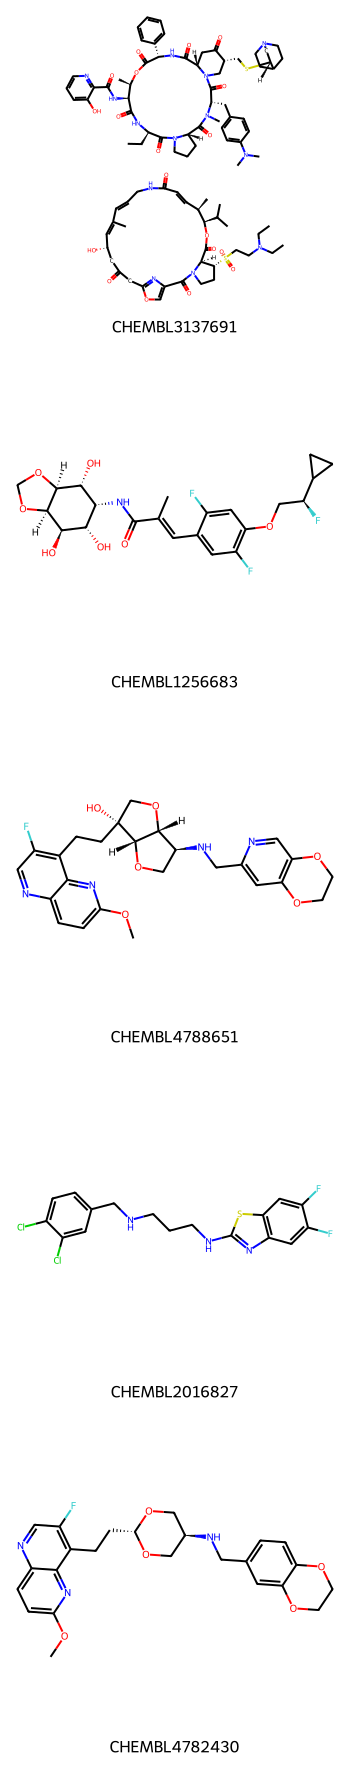

In [320]:
imgs = []
for sm in top5_each_algo[top5_each_algo.algo=='MolFormer'].itertuples():
    d2d = Draw.MolDraw2DCairo(350,350)
    molecule = Chem.MolFromSmiles(sm.Smiles)
    imgs.append(show_mol(d2d,molecule,legend=f'{sm.CID}'))
    # rdDepictor.Compute2DCoords(molecule)
    # rdDepictor.StraightenDepiction(molecule)
    # molecule

# imgs.append(show_mol(d2d,doravirine,legend='default palette'))
show_images(imgs)

350 1770


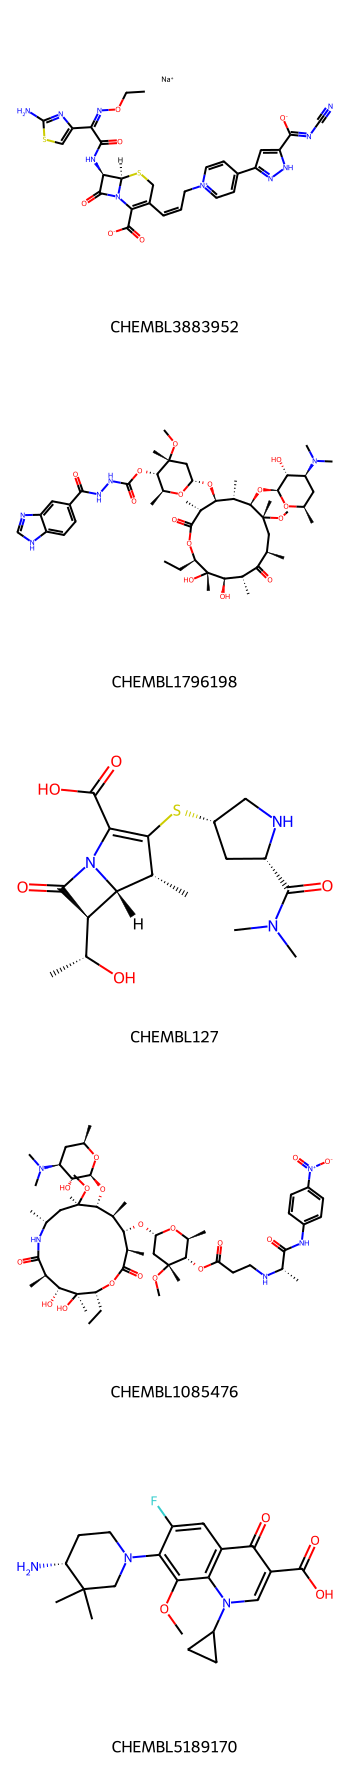

In [321]:
imgs = []
for sm in top5_each_algo[top5_each_algo.algo=='MolFormer'].itertuples():
    d2d2 = Draw.MolDraw2DCairo(350,350)
    molecule2 = Chem.MolFromSmiles(sm.Most_Similar_SMILES)
    imgs.append(show_mol(d2d2,molecule2,legend=f'{sm.Most_Similar_Compound_ID}'))
    # rdDepictor.Compute2DCoords(molecule)
    # rdDepictor.StraightenDepiction(molecule)
    # molecule

# imgs.append(show_mol(d2d,doravirine,legend='default palette'))
show_images(imgs)